In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [231]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost

In [5]:
np.random.seed(1767)

Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building. 

In [171]:
always_drop_columns = ['days_with_fog', 'direction_peak_wind_speed', 'max_wind_speed', 'direction_max_wind_speed'] + \
                      ['january_min_temp', 'cooling_degree_days'] # correlated 

In [172]:
def convert_facility_types(f_df, imax=5):
    vc = f_df['facility_type'].value_counts().index

    tmp = (f_df.loc[:, 'facility_type']).copy()
    f_df.loc[:, 'facility_type'] = 'other'

    for i in range(imax):
        print(i, vc[i])
        ix = tmp == vc[i]
        f_df.loc[ix, 'facility_type'] = vc[i]
    
    return f_df

In [173]:
def convert_year_factors(f_df):
    '''Group year factor 1 + 2 together'''
    ix = f_df.loc[:, 'year_factor'] == 1
    f_df.loc[ix, 'year_factor'] = 2
    
    return f_df

In [174]:
df = pd.read_csv('./data/train.csv.zip').drop(columns=['id'] + always_drop_columns)
df.columns = df.columns.str.lower()
df = df[~df.index.duplicated(keep='first')]

In [175]:
test_df = pd.read_csv('./data/test.csv.zip').drop(columns=always_drop_columns)
test_df.columns = test_df.columns.str.lower()

In [176]:
df = convert_facility_types(df, imax=9)
df = convert_year_factors(df)


test_df = convert_facility_types(test_df, imax=9)

0 Multifamily_Uncategorized
1 Office_Uncategorized
2 Education_Other_classroom
3 Lodging_Hotel
4 2to4_Unit_Building
5 Commercial_Other
6 5plus_Unit_Building
7 Warehouse_Nonrefrigerated
8 Retail_Uncategorized
0 Multifamily_Uncategorized
1 Office_Uncategorized
2 2to4_Unit_Building
3 Education_Other_classroom
4 5plus_Unit_Building
5 Lodging_Hotel
6 Commercial_Other
7 Retail_Uncategorized
8 Education_College_or_university


In [177]:
df.head()

,year_factor,state_factor,building_class,facility_type,floor_area,year_built,energy_star_rating,elevation,january_avg_temp,january_max_temp,...,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,site_eui
0,2,State_1,Commercial,other,61242.0,1942.0,11.0,2.4,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,2,State_1,Commercial,other,274000.0,1955.0,45.0,1.8,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,2,State_1,Commercial,other,280025.0,1951.0,97.0,1.8,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,2,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,2,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395


In [178]:
df.describe()

,year_factor,floor_area,year_built,energy_star_rating,elevation,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,...,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,site_eui
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000
mean,4.395699,1.659839e+05,1952.306764,61.048605,39.506323,34.310468,59.054952,11.720567,35.526837,58.486278,...,56.176705,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,82.584693
std,1.415655,2.468758e+05,37.053619,28.663683,60.656596,6.996108,5.355458,12.577272,8.866697,8.414611,...,2.241940,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,58.255403
min,2.000000,9.430000e+02,0.000000,0.000000,-6.400000,10.806452,42.000000,-13.000000,13.250000,38.000000,...,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001169
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,29.827586,56.000000,2.000000,31.625000,55.000000,...,55.147541,22.000000,5.000000,0.000000,0.000000,72.000000,6.000000,0.000000,0.000000,54.528601
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,34.451613,59.000000,9.000000,34.107143,61.000000,...,56.835616,50.000000,11.000000,2.000000,0.000000,84.000000,12.000000,0.000000,0.000000,75.293716
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,37.322581,62.000000,20.000000,40.879310,62.000000,...,57.215847,66.000000,26.000000,7.000000,0.000000,97.000000,17.000000,0.000000,0.000000,97.277534
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,64.758065,91.000000,48.000000,65.107143,89.000000,...,77.245205,170.000000,93.000000,59.000000,31.000000,260.000000,185.000000,119.000000,16.000000,997.866120


In [179]:
cat_columns = list(df.select_dtypes(['object']).columns)
cat_columns

['state_factor', 'building_class', 'facility_type']

In [180]:
num_columns = list(df.select_dtypes(['int', 'float']).columns)

In [181]:
for cc in cat_columns:
    df[f'{cc}_'] = df[cc].astype('category').cat.codes
    test_df[f'{cc}_'] = test_df[cc].astype('category').cat.codes    
df = df.drop(columns=cat_columns)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year_factor           75757 non-null  int64  
 1   floor_area            75757 non-null  float64
 2   year_built            73920 non-null  float64
 3   energy_star_rating    49048 non-null  float64
 4   elevation             75757 non-null  float64
 5   january_avg_temp      75757 non-null  float64
 6   january_max_temp      75757 non-null  int64  
 7   february_min_temp     75757 non-null  int64  
 8   february_avg_temp     75757 non-null  float64
 9   february_max_temp     75757 non-null  int64  
 10  march_min_temp        75757 non-null  int64  
 11  march_avg_temp        75757 non-null  float64
 12  march_max_temp        75757 non-null  int64  
 13  april_min_temp        75757 non-null  int64  
 14  april_avg_temp        75757 non-null  float64
 15  april_max_temp     

## Random Forest

In [204]:
unimportant_columns = ['state_factor_'] + ['june_avg_temp', 'march_avg_temp',
       'october_avg_temp', 'elevation', 'november_avg_temp',
       'january_max_temp', 'february_max_temp', 'march_max_temp',
       'november_min_temp', 'august_max_temp', 'october_min_temp',
       'june_max_temp', 'april_max_temp', 'days_above_110f']

'''
['february_max_temp', 'floor_area', 'august_min_temp', 'april_max_temp',
'july_min_temp',
'march_min_temp',
'elevation',
'days_above_90f',
'november_min_temp',
'april_min_temp',
'days_above_100f',
'february_min_temp',
'days_below_0f',
'july_max_temp',
'august_max_temp',
'february_avg_temp',
'days_below_20f',
'days_above_110f',
#                       
                       'precipitation_inches',
'october_avg_temp'       ,
'december_min_temp'       ,
'june_min_temp'          ,
'july_avg_temp'         ,
'october_min_temp'   ,    
'days_above_80f'         ,
'avg_temp'               ,
'march_avg_temp',]
'''

"\n['february_max_temp', 'floor_area', 'august_min_temp', 'april_max_temp',\n'july_min_temp',\n'march_min_temp',\n'elevation',\n'days_above_90f',\n'november_min_temp',\n'april_min_temp',\n'days_above_100f',\n'february_min_temp',\n'days_below_0f',\n'july_max_temp',\n'august_max_temp',\n'february_avg_temp',\n'days_below_20f',\n'days_above_110f',\n#                       \n                       'precipitation_inches',\n'october_avg_temp'       ,\n'december_min_temp'       ,\n'june_min_temp'          ,\n'july_avg_temp'         ,\n'october_min_temp'   ,    \n'days_above_80f'         ,\n'avg_temp'               ,\n'march_avg_temp',]\n"

In [205]:
features = list(df.drop(columns=['site_eui', 'year_factor'] + unimportant_columns).columns)

num_columns = [nc for nc in num_columns if nc in features] # update numerical columns

print(f'Keeping {len(features)} features')

Keeping 40 features


Settings below

In [206]:
transform_labels = False
transform_features = True
fill_missing_values = False
use_clipping = True

In [207]:
X = df.loc[:, features]
y = df.loc[:, 'site_eui']
year_factor = df.loc[:, 'year_factor']
X.shape

X

,floor_area,year_built,energy_star_rating,january_avg_temp,february_min_temp,february_avg_temp,march_min_temp,april_min_temp,april_avg_temp,may_min_temp,...,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,building_class_,facility_type_
0,61242.0,1942.0,11.0,50.500000,35,50.589286,40,41,55.500000,46,...,56.972603,0,0,0,0,14,0,0,0,9
1,274000.0,1955.0,45.0,50.500000,35,50.589286,40,41,55.500000,46,...,56.972603,0,0,0,0,14,0,0,0,9
2,280025.0,1951.0,97.0,50.500000,35,50.589286,40,41,55.500000,46,...,56.972603,0,0,0,0,14,0,0,0,9
3,55325.0,1980.0,46.0,50.500000,35,50.589286,40,41,55.500000,46,...,56.972603,0,0,0,0,14,0,0,0,3
4,66000.0,1985.0,100.0,50.500000,35,50.589286,40,41,55.500000,46,...,56.972603,0,0,0,0,14,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,20410.0,1995.0,8.0,43.451613,34,47.672414,35,40,56.266667,45,...,55.147541,6,0,0,0,25,3,0,0,6
75753,40489.0,1910.0,98.0,43.451613,34,47.672414,35,40,56.266667,45,...,55.147541,6,0,0,0,25,3,0,1,1
75754,28072.0,1917.0,NaN,36.612903,30,41.637931,29,34,50.183333,40,...,47.911202,26,2,0,0,6,0,0,0,2
75755,53575.0,2012.0,NaN,36.612903,30,41.637931,29,34,50.183333,40,...,47.911202,26,2,0,0,6,0,0,0,2


In [208]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold

logo = LeaveOneGroupOut()
print(logo.get_n_splits(X, y, year_factor), 'splits with the year factor')

kfold = KFold(shuffle=True)

if fill_missing_values:
    fill_values = X.median()
    X = X.fillna(fill_values)
    
if use_clipping:
    clip_lower = X.mean() - X.std() * 3
    clip_upper = X.mean() + X.std() * 3

    X = X.clip(lower=clip_lower, upper=clip_upper, axis=1)    

5 splits with the year factor


In [209]:
if transform_features:
    scaler = StandardScaler() #StandardScaler(), MinMaxScaler()
    X.loc[:, num_columns] = scaler.fit_transform(X.loc[:, num_columns])

if transform_labels:
    qtrafo = QuantileTransformer(output_distribution='normal')
    y = qtrafo.fit_transform(y.values.reshape(-1, 1)).squeeze()

In [210]:
# save as processed data
X.to_csv('./processed_data/X.csv', index=False)
y.to_csv('./processed_data/y.csv', index=False)
year_factor.to_csv('./processed_data/year_factor.csv', index=False)

In [211]:
# baseline: predict the mean of the target variable
baseline = mean_squared_error(y_valid, np.repeat(np.mean(y_valid), len(y_valid)), squared=False)

In [212]:
# from tuning for max(rmse)
params = {'n_estimators': 480, 'max_depth': 12, 'max_delta_step': 0, 'learning_rate': 0.00840022214922337, 'gamma': 50.80400649352217, 'min_child_weight': 47.011303081830135, 'subsample': 0.3268312108564796, 'colsample_bytree': 0.9166539712603599, 'colsample_bylevel': 0.865468088346213, 'colsample_bynode': 0.8034613751136797, 'reg_alpha': 0.0008185212081641112, 'reg_lambda': 0.15056494261201056, 'scale_pos_weight': 1.8158519680733314}
# from mean(rmse)
params = {'n_estimators': 324, 'max_depth': 14, 'max_delta_step': 0, 'learning_rate': 0.005547202663094081, 'gamma': 58.815476679636035, 'min_child_weight': 74.52085266394391, 'subsample': 0.8431573451724299, 'colsample_bytree': 0.7653088671742969, 'colsample_bylevel': 0.47151134813696816, 'colsample_bynode': 0.4857187281643829, 'reg_alpha': 0.0010262454786770247, 'reg_lambda': 6.174226707645141e-05, 'scale_pos_weight': 0.5738383774038491}

# from mean(score)
params = {'n_estimators': 764, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.007802891466915495, 'gamma': 86.5843552676085, 'min_child_weight': 80.56579598040926, 'subsample': 0.814039750998124, 'colsample_bytree': 0.5097219772140784, 'colsample_bylevel': 0.6970069427084373, 'colsample_bynode': 0.8884595730147044, 'reg_alpha': 0.00017303974556927415, 'reg_lambda': 0.005700083795837294, 'scale_pos_weight': 1.66045029951116}

****************************************
Evaluating on year_factor [2]
Train: 64582, Valid: 11175
R2:    0.15729247313192207
RMSE:  55.12018517932606
****************************************
Evaluating on year_factor [3]
Train: 64878, Valid: 10879
R2:    0.15634516531511145
RMSE:  55.95479385195216
****************************************
Evaluating on year_factor [4]
Train: 62811, Valid: 12946
R2:    0.3272299018317104
RMSE:  47.92754032625986
****************************************
Evaluating on year_factor [5]
Train: 57449, Valid: 18308
R2:    0.36206529046499525
RMSE:  45.15388909570008
****************************************
Evaluating on year_factor [6]
Train: 53308, Valid: 22449
R2:    0.29524889869277116
RMSE:  47.86576217101784


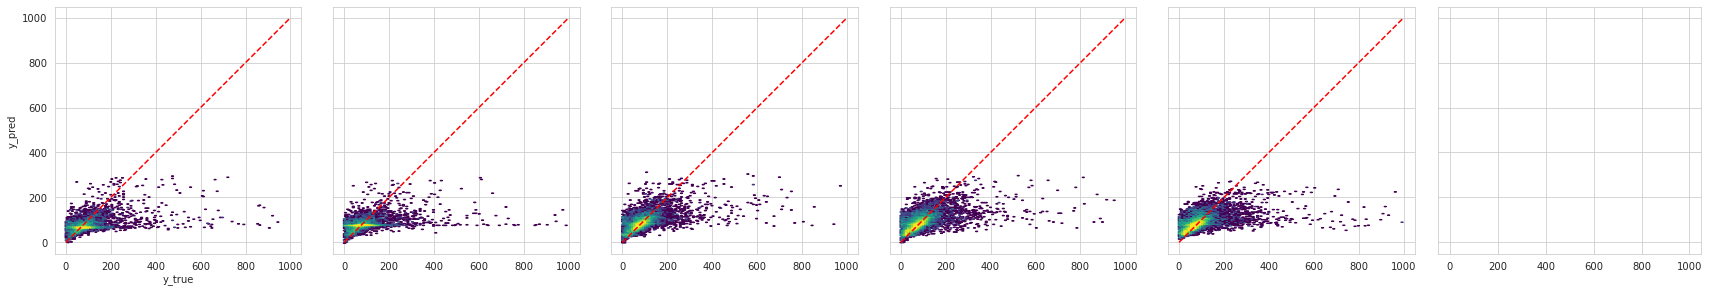

Average Validation RMSE: 50.40 (-15.83 % to baseline)


In [222]:
fig, ax = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(24, 4))
ax = ax.flatten()
i = 0

models = []
feature_importance_df = []
valid_rmses = []


for train_index, valid_index in logo.split(X, y, year_factor):
#for train_index, valid_index in kfold.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]

    rfr = xgboost.XGBRegressor(**params, random_state=700)
    rfr = rfr.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
                  early_stopping_rounds=10, 
                  verbose=0)
    
    print('*'*40)
    print('Evaluating on year_factor', year_factor.iloc[valid_index].unique())
    print(f'Train: {len(y_train)}, Valid: {len(y_valid)}')
    print('R2:   ', rfr.score(X_valid, y_valid))
    
    y_valid_hat = rfr.predict(X_valid)
    if transform_labels:
        y_valid = qtrafo.inverse_transform(y_valid.reshape(-1, 1)).squeeze()
        y_valid_hat = qtrafo.inverse_transform(y_valid_hat.reshape(-1, 1)).squeeze() 
        
    rmse = mean_squared_error(y_valid, y_valid_hat, squared=False)
    print('RMSE: ', rmse)
    
    ax[i].hexbin(y_valid, y_valid_hat, cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=100), mincnt=1)
    ax[i].set_aspect('equal')
    ax[i].plot(np.arange(0, 1000), np.arange(0, 1000), 'r--')
    i += 1
    
    models.append(rfr)
    feature_importance_df.append(pd.DataFrame(rfr.feature_importances_, index=features))
    valid_rmses.append(rmse)
        
feature_importance_df = pd.concat(feature_importance_df, axis=1)

ax[0].set_xlabel('y_true')
ax[0].set_ylabel('y_pred')
fig.tight_layout()
plt.show()

v = np.mean(valid_rmses)
print(f'Average Validation RMSE: {v:.2f} ({1e2*(v/baseline - 1):+.2f} % to baseline)')

In [223]:
feature_importance_df.max(axis=1).sort_values(ascending=False)

energy_star_rating      0.145600
heating_degree_days     0.081800
facility_type_          0.077008
days_below_20f          0.076237
january_avg_temp        0.061064
february_avg_temp       0.057573
snowfall_inches         0.054442
building_class_         0.045042
march_min_temp          0.044570
snowdepth_inches        0.041226
days_below_0f           0.037139
days_below_30f          0.036893
february_min_temp       0.029917
floor_area              0.025005
days_above_100f         0.024724
july_min_temp           0.021159
days_below_10f          0.021108
august_min_temp         0.020643
year_built              0.019538
june_min_temp           0.017996
april_avg_temp          0.017862
days_above_90f          0.017445
april_min_temp          0.017162
november_max_temp       0.016961
august_avg_temp         0.016099
days_above_80f          0.015972
july_avg_temp           0.015819
december_avg_temp       0.015369
may_min_temp            0.015099
avg_temp                0.014763
october_ma

### Generate test set predictions

In [224]:
X_test = test_df.loc[:, features]

if fill_missing_values:
    X_test = X_test.fillna(fill_values)
    
if use_clipping:
    X_test = X_test.clip(lower=clip_lower, upper=clip_upper, axis=1)

print(X_test.shape, len(features))

if transform_features:
    X_test.loc[:, num_columns] = scaler.transform(X_test.loc[:, num_columns])

print(pd.DataFrame(X_test).describe())

(9705, 40) 40
        floor_area   year_built  energy_star_rating  january_avg_temp  \
count  9705.000000  9613.000000         7451.000000       9705.000000   
mean     -0.019226     0.338048            0.127840          0.342199   
std       1.045587     1.096368            0.974622          1.002279   
min      -0.859118    -3.441565           -2.094958         -0.970920   
25%      -0.616963    -0.726335           -0.559899         -0.970920   
50%      -0.418425     0.509911            0.382069          0.627444   
75%       0.129007     1.282564            0.940272          0.989337   
max       4.328851     1.962499            1.358925          2.344118   

       february_min_temp  february_avg_temp  march_min_temp  april_min_temp  \
count        9705.000000        9705.000000     9705.000000     9705.000000   
mean            0.793860           0.688928        0.153876        0.481289   
std             0.777171           0.623568        1.155401        0.968623   
min         

In [225]:
weights = 1 / np.array(valid_rmses)
weights = weights / np.sum(weights)
print(weights)

[0.18157277 0.17886448 0.208822   0.22164923 0.20909152]


In [226]:
y_hat = []

for rfr in models:
    yy = rfr.predict(X_test)
    if transform_labels:
        yy = qtrafo.inverse_transform(yy.reshape(-1, 1)).squeeze()
    y_hat.append(yy)
    
y_hat = np.average(np.asarray(y_hat), weights=weights, axis=0)

In [227]:
test_df['site_eui'] = y_hat
submission_df = test_df.loc[:, ['id', 'site_eui']]

<AxesSubplot:>

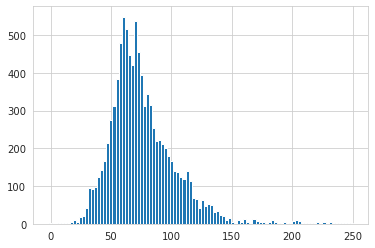

In [228]:
submission_df['site_eui'].hist(bins=100)

In [230]:
submission_file = '20220125_random_forest_10.csv'

if os.path.exists(os.path.join('submissions', submission_file)):
    assert False
submission_df.to_csv(os.path.join('submissions', submission_file), index=False)